# Initialize

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# Load Data

In [2]:
df = pd.read_csv("../data/casestudy.csv", index_col = [0])

# initialize resultant dataframe
yeardf = pd.DataFrame(index=df['year'].unique(), 
                      columns=['Total Revenue', 
                               'New Customer Revenue',
                               'Existing Customer Growth',
                               'Revenue Loss from Attrition',
                               'Existing Customer Revenue Current Year',
                               'Existing Customer Revenue Prior Year',
                               'Total Customers Current Year',
                               'Total Customers Previous Year',
                               'New Customers',
                               'Lost Customers'])

# pivot table to get new and existing customer information
pivot = df.pivot(index='customer_email', columns='year', values='net_revenue')

num_years = df['year'].unique().size

# Gather information

In [3]:
pivot_matrix = pivot.to_numpy(copy=True)

# transpose matrix along anti diagonal to loop through years backwards
transpose_matrix = pivot_matrix[::-1, ::-1].T

prev = 0
rows = transpose_matrix.shape[0]
cols = transpose_matrix.shape[1]

# loop through every year
for i in range(1, rows):
    # loop through every customer
    for j in range(0, cols):
        # if year and prev year are not nan set year to nan
        if np.isnan(transpose_matrix[prev][j]):
            continue
        else:
            if not np.isnan(transpose_matrix[i][j]):
                transpose_matrix[prev][j] = np.nan
    prev = i

# transpose matrix back and make it a dataframe
pivot_matrix = transpose_matrix[::-1, ::-1].T
newcustdf = pd.DataFrame()

# add year labels to dataframe
for i in range(num_years):
    title = 2015 + i
    newcustdf.insert(len(newcustdf.columns), title, pivot_matrix[:, i])

# compute information about new customers from new dataframe
yeardf['Total Revenue'] = pivot.sum()
yeardf['New Customer Revenue'] = newcustdf.sum()
yeardf['Total Customers Current Year'] = pivot.count()
yeardf['Total Customers Previous Year'] = yeardf['Total Customers Current Year'].shift(1)
yeardf['New Customers'] = newcustdf.count()

In [4]:
# for every year gather information
for i in range(1, num_years):
    currkey = 2015 + i
    prevkey = currkey - 1
    # slice of existing customers
    dfslice = pivot[pivot[prevkey].notna() & pivot[currkey].notna()]
    revenues = dfslice.sum() # revenue from existing customers
    customers = dfslice.count() # number of existing customers

    # add data to resultant dataframe
    yeardf.loc[currkey, 'Existing Customer Growth'] = revenues[currkey] - revenues[prevkey]
    yeardf.loc[currkey, 'Revenue Loss from Attrition'] = yeardf.loc[prevkey, 'Total Revenue'] - revenues[currkey]
    yeardf.loc[currkey, 'Existing Customer Revenue Current Year'] = revenues[currkey]
    yeardf.loc[currkey, 'Existing Customer Revenue Prior Year'] = revenues[prevkey]
    yeardf.loc[currkey, 'Lost Customers'] = yeardf.loc[prevkey, 'Total Customers Current Year'] - customers[currkey]

# Data for Each Year

In [5]:
yeardf

,Total Revenue,New Customer Revenue,Existing Customer Growth,Revenue Loss from Attrition,Existing Customer Revenue Current Year,Existing Customer Revenue Prior Year,Total Customers Current Year,Total Customers Previous Year,New Customers,Lost Customers
2015,29036749.19,29036749.19,NaN,NaN,NaN,NaN,231294,NaN,231294,NaN
2016,25730943.59,18245491.01,20335.46,21551296.61,7485452.58,7465117.12,204646,231294.0,145062,171710
2017,31417495.03,28776235.04,20611.34,23089683.6,2641259.99,2620648.65,249987,204646.0,229028,183687


# Visualizations

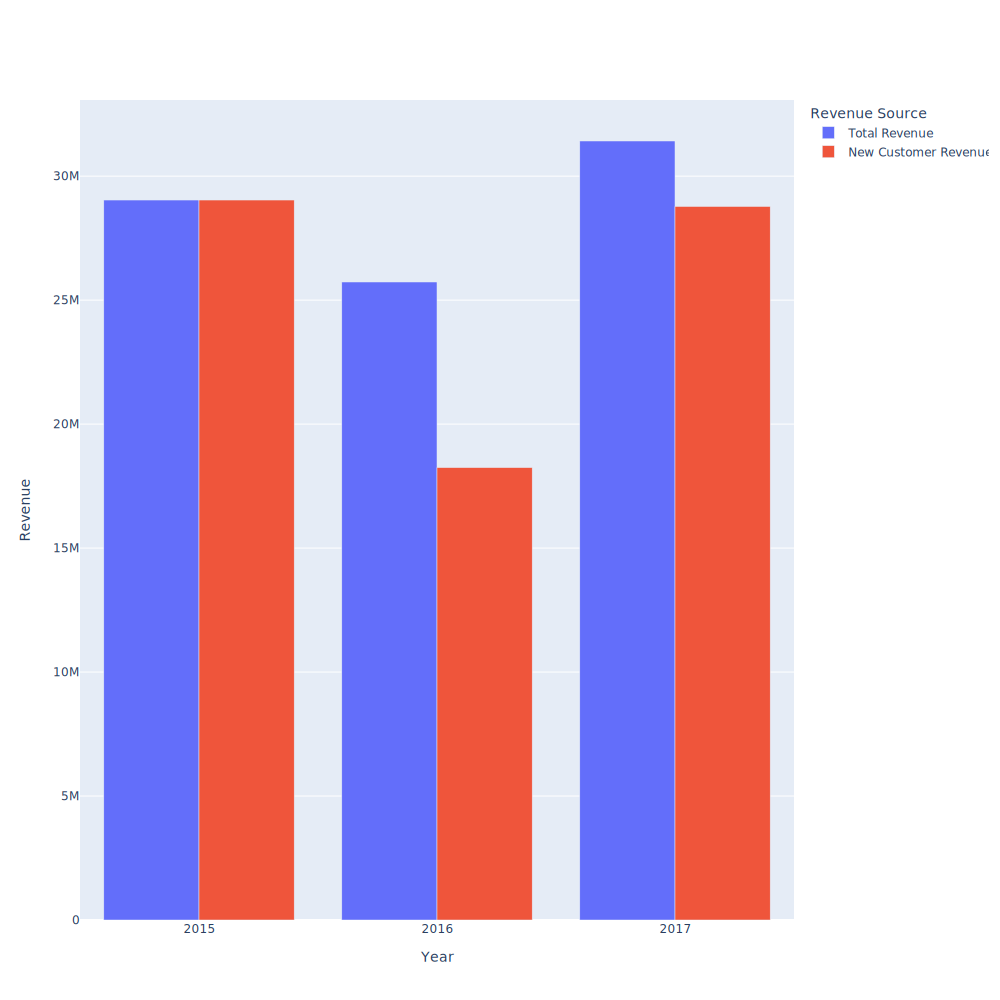

In [6]:
fig = go.Figure(data=[
    go.Bar(name='Total Revenue', x=yeardf.index.astype(str), y=yeardf['Total Revenue']),
    go.Bar(name='New Customer Revenue', x=yeardf.index.astype(str), y=yeardf['New Customer Revenue'])
])
fig.update_layout(barmode='group')
fig.update_layout(xaxis_title='Year', yaxis_title='Revenue', legend_title='Revenue Source')
fig.update_layout(width=1000, height=1000)
fig.show(renderer='svg')

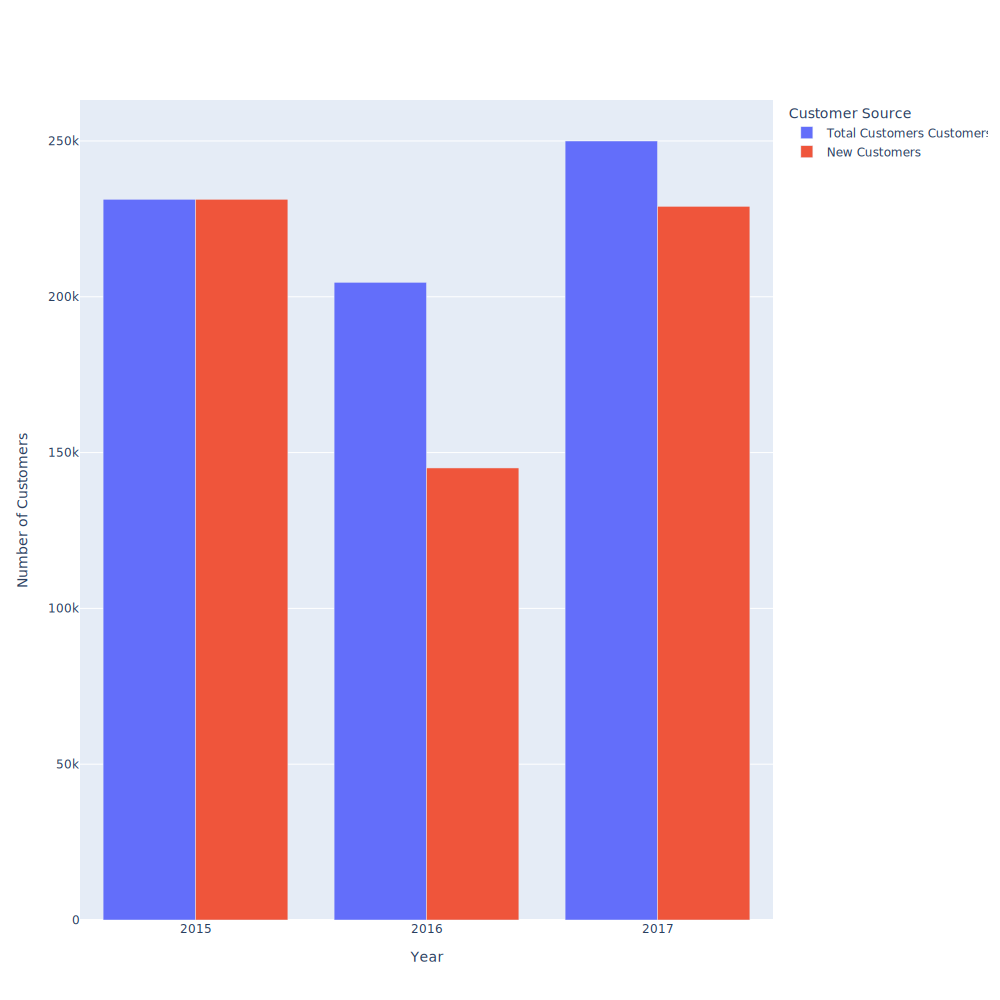

In [7]:
fig = go.Figure(data=[
    go.Bar(name='Total Customers Customers', x=yeardf.index.astype(str), y=yeardf['Total Customers Current Year']),
    go.Bar(name='New Customers', x=yeardf.index.astype(str), y=yeardf['New Customers']),
])
fig.update_layout(barmode='group')
fig.update_layout(xaxis_title='Year', yaxis_title='Number of Customers', legend_title='Customer Source')
fig.update_layout(width=1000, height=1000)
fig.show(renderer='svg')

In [8]:
df['starting_letter'] = [x.lstrip()[0] for x in df['customer_email']]
bar_source = df.groupby(df['starting_letter']).count()

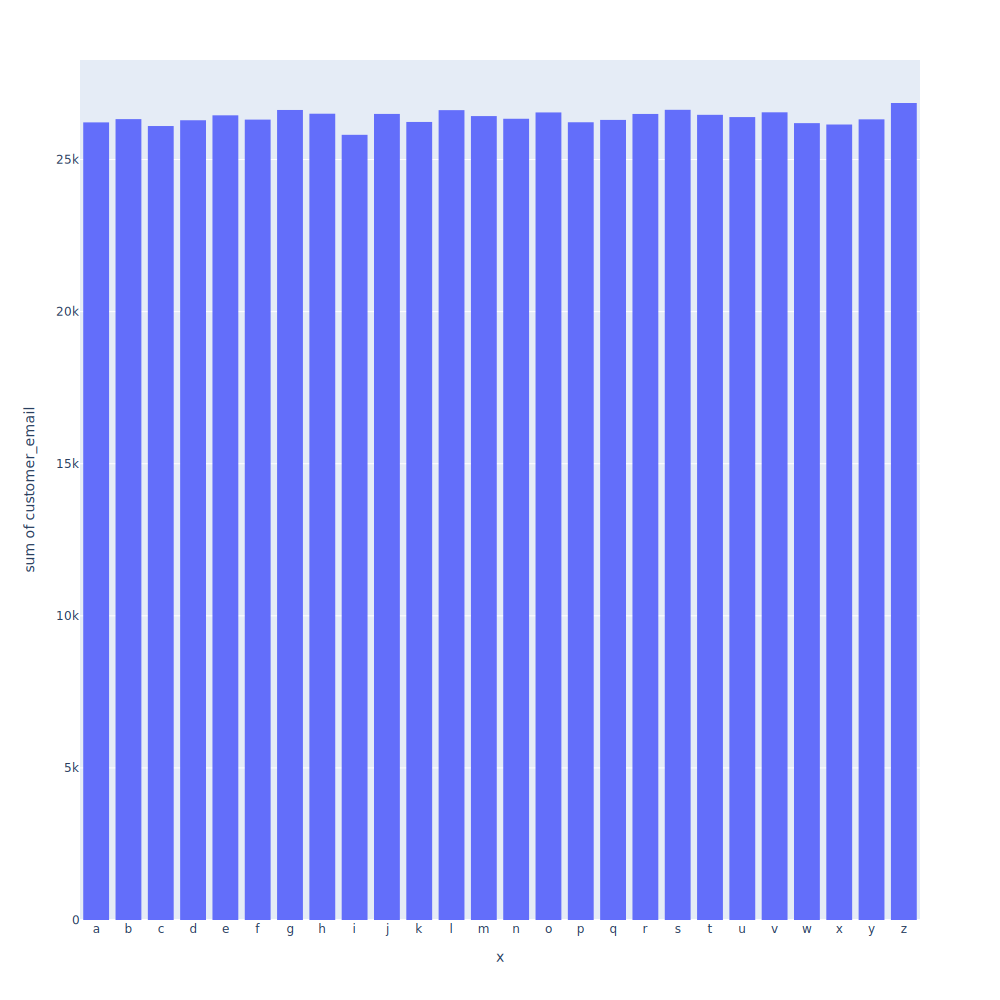

In [9]:
fig = px.histogram(bar_source, x=bar_source.index.astype(str), y='customer_email')
fig.update_layout(width=1000, height=1000)
fig.show(renderer='svg')

The above graphs show that the distribution of email address first letters is constant. That makes me think that the dataset is not representative of real world data.